In [22]:
import functools as ft
import pickle
import time
from datetime import datetime

import equinox as eqx
import jax
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import numpy as np
import optax
import scienceplots  # noqa: F401
from jaxtyping import Array, Float

from snnax import (
    FeedForwardSNN,
    SpikingNeuralNet,
    _build_forward_network,
    cap_fill_ravel,
    expected_signature_loss,
    marcus_lift,
    signature_mmd,
    spike_MAE_loss,
    spike_MSE_loss,
)

TRAIN = False
SAVE_IDX = datetime.today().strftime("%Y-%m-%d-%H")
key = jr.PRNGKey(1234)

## Generate data

In [2]:
sample_sizes = [256, 512, 1024]
batch_size = 128
step_strategy = (1000, 500)
num_save = 2  # Increase this to get nicer plots below
potential_spike_cap = 2
w_sum = 3
t0 = 0
t1 = 1
v_reset = 1.2
v_th = 1
alpha = 3e-2
beta = 5
tau_s = 1
mu = np.array([6, 5])
sigma = 0.25 * jnp.eye(2)
max_spikes = 100
dt0 = 1e-2
diffusion = True


# Cap exp function for numerical stability
def intensity_fn(v: Float) -> Float:
    return jnp.exp(beta * (jnp.minimum(v - v_th, 10))) / tau_s


# Constant input current
def input_current(t: Float) -> Array:
    return jnp.array([1.5] * 4)


def generate_weights(in_size, out_size, width_size, depth, key, w_sum=10.0):
    num_neurons = in_size + width_size * (depth - 1) + out_size
    w = jnp.zeros((num_neurons, num_neurons))
    layer_list = np.array([0] + [in_size] + [width_size] * (depth - 1) + [out_size])
    layer_idx = np.cumsum(np.array(layer_list))
    for i in range(depth):
        w_key = jr.fold_in(key, i)
        lrows = layer_idx[i]
        urows = layer_idx[i + 1]
        lcols = layer_idx[i + 1]
        ucols = layer_idx[i + 2]
        layer_size = layer_list[i + 1]
        w_fill = jr.uniform(w_key, (urows - lrows, ucols - lcols), minval=0.5, maxval=1.5)
        w_fill = w_fill * (w_sum / layer_size)
        w = w.at[lrows:urows, lcols:ucols].set(w_fill)
    return w


@eqx.filter_jit
def get_data(
    data_size, in_size, width_size, depth, out_size, key, w_key, input_current, n_observed=None
):
    key, init_key = jr.split(key, 2)
    num_neurons = in_size + width_size * (depth - 1) + out_size
    network = _build_forward_network(in_size, out_size, width_size, depth)
    w = generate_weights(in_size, out_size, width_size, depth, w_key, w_sum)
    v0 = jnp.full((data_size, num_neurons), v_reset - 1e-1)
    i0 = jnp.full((data_size, num_neurons), v_reset / 2)
    n_observed = out_size if n_observed is None else n_observed

    def _input_current(t: Float) -> Array:
        return jnp.hstack([input_current(t), jnp.zeros((num_neurons - in_size,))])

    snn_true = SpikingNeuralNet(
        num_neurons=num_neurons,
        intensity_fn=intensity_fn,
        v_reset=v_reset,
        alpha=alpha,
        w=w,
        network=network,
        mu=mu,
        sigma=sigma,
        key=init_key,
        diffusion=diffusion,
    )

    sol = snn_true(
        _input_current,
        t0,
        t1,
        max_spikes,
        data_size,
        key=key,
        i0=i0,
        v0=v0,
        num_save=num_save,
        dt0=dt0,
    )

    @jax.vmap
    def get_marcus_lifts(spike_times, spike_marks):
        return marcus_lift(t0, t1, spike_times, spike_marks[:, -n_observed:])

    @jax.vmap
    def get_potentials(ts, ys):
        _ts, _ys = cap_fill_ravel(ts, ys, potential_spike_cap)
        potentials = _ys[-n_observed:, :, 0]
        potentials = jnp.vstack([_ts, potentials])
        # (neurons, times) -> (times, neurons)
        potentials = jnp.transpose(potentials, (1, 0))
        return potentials

    spike_trains = get_marcus_lifts(sol.spike_times, sol.spike_marks)
    potentials = get_potentials(sol.ts, sol.ys)

    return spike_trains, potentials


def dataloader(data, batch_size, loop, *, key):
    spike_trains, potentials = data
    data_size, _, _ = spike_trains.shape
    indices = jnp.arange(data_size)
    while True:
        perm = jr.permutation(key, indices)
        key = jr.split(key, 1)[0]
        start = 0
        end = batch_size
        while end < data_size:
            batch_perm = perm[start:end]
            yield (spike_trains[batch_perm], potentials[batch_perm])
            start = end
            end = start + batch_size
        if not loop:
            break

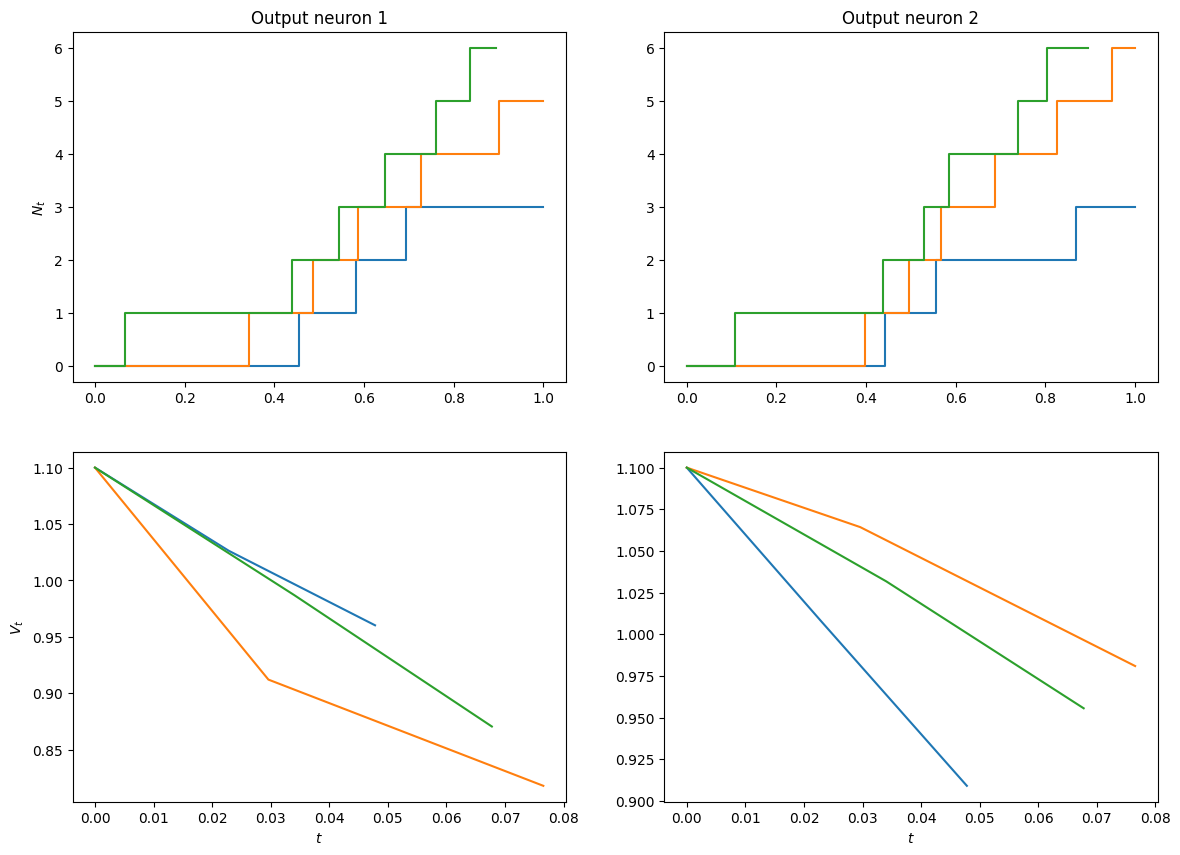

In [3]:
key, w_key, data_key = jr.split(key, 3)
spike_trains, potentials = get_data(
    data_size=16,
    in_size=4,
    width_size=16,
    depth=2,
    out_size=2,
    key=data_key,
    w_key=w_key,
    input_current=input_current,
    n_observed=22,
)

start_idx, stop_idx = 0, 3
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))

ax[0, 0].plot(spike_trains[start_idx:stop_idx, :, 0].T, spike_trains[start_idx:stop_idx, :, -2].T)
ax[0, 0].set_title("Output neuron 1")
ax[0, 0].set_ylabel(r"$N_t$")
ax[0, 1].plot(spike_trains[start_idx:stop_idx, :, 0].T, spike_trains[start_idx:stop_idx, :, -1].T)
ax[0, 1].set_title("Output neuron 2")

ax[1, 0].plot(potentials[start_idx:stop_idx, :, 0].T, potentials[start_idx:stop_idx, :, -2].T)
ax[1, 0].set_ylabel(r"$V_t$")
ax[1, 0].set_xlabel(r"$t$")
ax[1, 1].plot(potentials[start_idx:stop_idx, :, 0].T, potentials[start_idx:stop_idx, :, -1].T)
ax[1, 1].set_xlabel(r"$t$");

## Loss functions

In [4]:
def get_spike_trains(model, input_current, batch_size, key, n_observed=None):
    out_size = model.out_size
    n_observed = out_size if n_observed is None else n_observed

    v0 = jnp.full((batch_size, model.num_neurons), v_reset - 1e-1)
    i0 = jnp.full((batch_size, model.num_neurons), v_reset / 2)

    key, batch_key = jr.split(key, 2)
    _sol = model(
        input_current,
        t0,
        t1,
        max_spikes,
        batch_size,
        key=batch_key,
        v0=v0,
        i0=i0,
        dt0=dt0,
    )

    @jax.vmap
    def get_marcus_lifts(spike_times, spike_marks):
        return marcus_lift(t0, t1, spike_times, spike_marks[:, -n_observed:])

    return get_marcus_lifts(_sol.spike_times, _sol.spike_marks)


def get_potentials(model, input_current, batch_size, key, n_observed=None):
    out_size = model.out_size
    n_observed = out_size if n_observed is None else n_observed

    v0 = jnp.full((batch_size, model.num_neurons), v_reset - 1e-1)
    i0 = jnp.full((batch_size, model.num_neurons), v_reset / 2)

    key, batch_key = jr.split(key, 2)
    _sol = model(
        input_current,
        t0,
        t1,
        max_spikes,
        batch_size,
        key=batch_key,
        v0=v0,
        i0=i0,
    )

    @jax.vmap
    def get_potentials(ts, ys):
        _ts, _ys = cap_fill_ravel(ts, ys, potential_spike_cap)
        potentials = _ys[-n_observed:, :, 0]
        potentials = jnp.vstack([_ts, potentials])
        # (neurons, times) -> (times, neurons)
        potentials = jnp.transpose(potentials, (1, 0))
        return potentials

    return get_potentials(_sol.ts, _sol.ys)


# First n spikes moment matching loss
@eqx.filter_jit
def fs_loss(model, input_current, data, batch_size, key, n_observed=None, n=1):
    spike_trains_true, _ = data
    spike_trains_gen = get_spike_trains(model, input_current, batch_size, key, n_observed)
    return spike_MSE_loss(spike_trains_gen, spike_trains_true, n=n)


# Expected signature loss on spike trains
@eqx.filter_jit
def spike_train_es_loss(
    model, input_current, data, batch_size, key, n_observed=None, depth=2, match_spikes=True
):
    spike_trains_true, _ = data
    spike_trains_gen = get_spike_trains(model, input_current, batch_size, key, n_observed)
    return expected_signature_loss(
        spike_trains_gen, spike_trains_true, depth=depth, match_spikes=match_spikes
    )


# Expected signature loss on potentials
@eqx.filter_jit
def potential_es_loss(model, input_current, data, batch_size, key, n_observed=None, depth=2):
    _, potentials_true = data
    potentials_gen = get_potentials(model, input_current, batch_size, key, n_observed)
    return expected_signature_loss(potentials_gen, potentials_true, depth=depth, match_spikes=False)


# First n average spike times L1 loss
@eqx.filter_jit
def fs_mae_loss(model, input_current, data, batch_size, key, n_observed=None, n=1):
    spike_trains_true, _ = data
    spike_trains_gen = get_spike_trains(model, input_current, batch_size, key, n_observed)
    return spike_MAE_loss(spike_trains_gen, spike_trains_true, n=n)


# Signature kenrel MMD loss
@eqx.filter_jit
def sig_mmd_loss(
    model,
    input_current,
    data,
    batch_size,
    key,
    n_observed=None,
    match_spikes=True,
    scales=None,
    refinement_factor=2,
):
    spike_trains_true, _ = data
    spike_trains_gen = get_spike_trains(model, input_current, batch_size, key, n_observed)
    return signature_mmd(
        spike_trains_gen, spike_trains_true, match_spikes, scales, refinement_factor
    )

## Training loop

In [5]:
@eqx.filter_jit
def make_step(
    model, grad_loss, optim, input_current, data, batch_size, opt_state, key, n_observed=None
):
    loss, grads = grad_loss(model, input_current, data, batch_size, key, n_observed=n_observed)
    updates, opt_state = optim.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    return loss, model, opt_state


def train(
    input_current,
    loss,
    *,
    test_loss=None,
    in_size=4,
    width_size=16,
    depth=2,
    out_size=2,
    data_size=1024,
    n_observed=None,
    lr_strategy=(3e-3, 1e-3),
    step_strategy=(500, 500),
    batch_strategy=(128, 128),
    steps_per_print=10,
    seed=456,
):
    shape_dtype = eqx.filter_eval_shape(input_current, 0.0)
    assert in_size == shape_dtype.shape[0]
    total_steps = sum(step_strategy)
    min_batch_size = min(batch_strategy)

    num_neurons = in_size + width_size * (depth - 1) + out_size
    n_observed = out_size if n_observed is None else n_observed
    n_observed = num_neurons if n_observed == "all" else n_observed

    key = jr.PRNGKey(seed)
    (
        data_key,
        test_key,
        w_key,
        dataloader_key,
        generator_key,
        step_key,
    ) = jr.split(key, 6)

    generator = FeedForwardSNN(
        in_size=in_size,
        out_size=out_size,
        width_size=width_size,
        depth=depth,
        intensity_fn=intensity_fn,
        v_reset=v_reset,
        alpha=alpha,
        mu=mu,
        sigma=sigma,
        key=generator_key,
        diffusion=diffusion,
        wmin=0.0,
        wmax=1.0,
    )

    grad_loss = eqx.filter_value_and_grad(loss)
    if test_loss is None:
        test_loss = ft.partial(fs_mae_loss, n=5)

    # Generate data: We do it in batches since if the data size is too large
    # the underlying DE that is solved will be too high-dimensional.
    assert data_size % min_batch_size == 0
    num_batches = data_size // min_batch_size
    spike_trains = jnp.zeros((data_size, 2 * max_spikes, num_neurons + 1))
    potentials = jnp.zeros((data_size, num_save * potential_spike_cap, num_neurons + 1))
    print("Generating data...")
    for i in range(num_batches):
        data_key = jr.fold_in(data_key, i)
        spike_train, potential = get_data(
            min_batch_size,
            in_size,
            width_size,
            depth,
            out_size,
            data_key,
            w_key,
            input_current,
            n_observed=n_observed,
        )
        li, ui = i * min_batch_size, (i + 1) * min_batch_size
        spike_trains = spike_trains.at[li:ui].set(spike_train)
        potentials = potentials.at[li:ui].set(potential)
        print(f"Batch {i + 1} / {num_batches} done.")
    data = (spike_trains, potentials)

    test_data = get_data(
        max(batch_strategy),
        in_size,
        width_size,
        depth,
        out_size,
        test_key,
        w_key,
        input_current,
        n_observed=n_observed,
    )
    print("Data generated. Starting training...")

    w_true = generate_weights(in_size, out_size, width_size, depth, w_key, w_sum)
    loss_hist = []
    test_loss_hist = []
    params_hist = np.zeros((total_steps, num_neurons, num_neurons))
    steps_cnt = 0
    for lr, steps, batch_size in zip(lr_strategy, step_strategy, batch_strategy):
        optim = optax.rmsprop(lr, momentum=0.3)
        opt_state = optim.init(eqx.filter(generator, eqx.is_inexact_array))
        infinite_dataloader = dataloader(data, batch_size, loop=True, key=dataloader_key)

        for step, dat_i in zip(range(steps_cnt, steps_cnt + steps), infinite_dataloader):
            start = time.time()
            step = jnp.asarray(step)
            step_key = jr.fold_in(step_key, step)
            score, generator, opt_state = make_step(
                generator,
                grad_loss,
                optim,
                input_current,
                dat_i,
                batch_size,
                opt_state,
                step_key,
                n_observed=n_observed,
            )
            test_score = test_loss(
                generator,
                input_current,
                test_data[:batch_size],
                batch_size,
                step_key,
                n_observed=n_observed,
            )
            w_current = generator.w
            loss_hist.append(score)
            test_loss_hist.append(test_score)
            params_hist[step] = w_current
            end = time.time()
            if (step % steps_per_print) == 0 or step == steps_cnt + steps - 1:
                print(
                    f"Step: {step}, Loss: {score}, Test loss: {test_score},"
                    f"Computation time: {end - start}"
                )

        steps_cnt += steps

    results = {
        "loss_hist": loss_hist,
        "test_loss_hist": test_loss_hist,
        "params_hist": params_hist,
        "w_true": w_true,
    }
    return generator, results

## Truncated signature MMD

We restrict our attention to the truncated signature kernel MMD of depth 3, but other loss functions are entirely possible.

In [6]:
if TRAIN:
    sig_loss = ft.partial(spike_train_es_loss, depth=3)
    test_loss = ft.partial(spike_train_es_loss, depth=3, match_spikes=False)
    for n in sample_sizes:
        res_name = str(n)
        res = train(
            input_current,
            sig_loss,
            test_loss=test_loss,
            width_size=16,
            depth=2,
            data_size=n,
            lr_strategy=(3e-3, 1e-3),
            batch_strategy=(128, 128),
            step_strategy=step_strategy,
            n_observed="all",
        )
        final_model, res_dict = res
        fname = "./data/spiking_neural_net_" + str(n) + "_" + SAVE_IDX
        # Save results
        with open(fname, "wb") as f:
            pickle.dump(res_dict, f)
        print("")

## Plot results

In [62]:
def plot_results(res_dict):
    with plt.style.context(["science"]):
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
        for key, res in res_dict.items():
            ax[0].plot(res["test_loss_hist"], lw=1, label=f"{key}")
            ax[1].plot(res["params_dist_hist"], lw=1, label=f"{key}")
        ax[0].set_xlabel("Step")
        ax[0].set_title("Test loss")
        ax[1].set_title(r"$\|\hat{w}_{step} - w_{true}\|$")
        ax[1].set_xlabel("Step")
        ax[1].legend(loc="upper right", title="Sample size")

        # Save figure
        plt.savefig(
            "./figures/spiking_neural_net_" + SAVE_IDX + ".pdf", dpi=200, bbox_inches="tight"
        )

In [63]:
# Load results
res_dict = {}
for n in sample_sizes:
    # Change SAVE_IDX if you want to load results from a different run
    fname = "./data/spiking_neural_net_" + str(n) + "_" + SAVE_IDX
    with open(fname, "rb") as f:
        res_dict[n] = pickle.load(f)

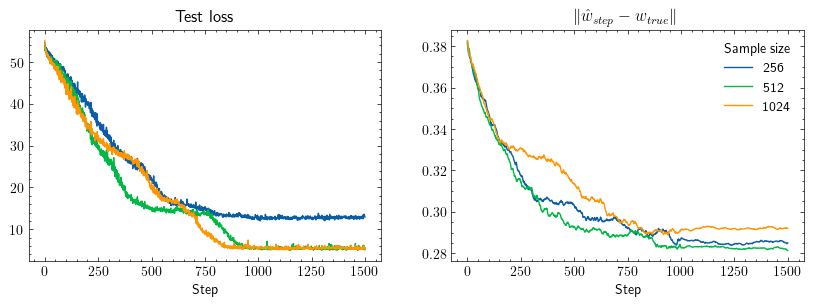

In [64]:
for n in sample_sizes:
    params = res_dict[n]["params_hist"]
    w_true = res_dict[n]["w_true"]
    params_dist = jnp.abs(params - w_true)
    params_dist = jnp.where(params_dist == 0, jnp.nan, params_dist)
    params_dist = jnp.nanmean(params_dist, axis=(1, 2))
    res_dict[n]["params_dist_hist"] = params_dist

# Plot results
plot_results(res_dict)